<a href="https://colab.research.google.com/github/andythomasc/Text-Style-Transfer/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instance check

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Sep  4 12:41:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import pandas as pd
from pandas import DataFrame
import numpy as np

import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import os


import time
import torchtext

from torchtext.legacy import data
import torch

#from utils import tensor2text
import torch.nn.functional as F

import math

from torch import nn, optim
#from tensorboardX import SummaryWriter
from torch.nn.utils import clip_grad_norm_

#from evaluator import Evaluator
#from utils import tensor2text, calc_ppl, idx2onehot, add_noise, word_drop


In [3]:

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset


#Transformer


In [4]:


import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out


class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out


class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=2,
        forward_expansion=1024,
        heads=4,
        dropout=0.1,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

#Loading Data and stuff

In [5]:
text_layperson = open('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/label_1_parallel.txt').read().splitlines()
text_expert = open('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/label_0_parallel.txt').read().splitlines()


concatenated = []

for i in range(len(text_layperson)):
  concatenated.append(text_layperson[i])
  concatenated.append(text_expert[i])

together = []

for i in range(len(text_layperson)):
  together.append((text_layperson[i],text_expert[i]))

#Vocab

In [6]:
import spacy  # for tokenizer


spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
vocab = Vocabulary(1)
vocab.build_vocabulary(concatenated)

In [7]:
## the custom dataset is better off having the things as a tuple or some shit, rather than what this abomination is.


In [8]:
#numericalized_caption = [self.vocab.stoi["<SOS>"]]
#numericalized_caption += self.vocab.numericalize(caption)
#numericalized_caption.append(self.vocab.stoi["<EOS>"])

#Custom DAtaset

In [9]:
pad_idx = vocab.stoi["<PAD>"]

In [10]:
class CustomTextDataset(Dataset):
  def __init__(self,expert,layperson,whole):
    #parse arguments such as the list of tokens
    self.expert = expert
    self.layperson = layperson
    self.whole=whole
    
    #create vocab and build ??

  def __len__(self):
    return len(self.whole)


  def __getitem__(self, idx):
    exp = self.expert[idx]
    lay = self.layperson[idx]

    numericalized_exp = [vocab.stoi["<SOS>"]]
    numericalized_exp +=vocab.numericalize(exp)
    numericalized_exp.append(vocab.stoi["<EOS>"])

    numericalized_lay = [vocab.stoi["<SOS>"]]
    numericalized_lay +=vocab.numericalize(lay)
    numericalized_lay.append(vocab.stoi["<EOS>"])

    return torch.tensor(numericalized_lay),torch.tensor(numericalized_exp)

  #  return self.whole[idx]


In [11]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        lay = [item[0] for item in batch]
        lay = pad_sequence(lay, batch_first=False, padding_value=self.pad_idx)
        exp = [item[1] for item in batch]
        exp = pad_sequence(exp, batch_first=False, padding_value=self.pad_idx)

        return lay, exp

In [12]:
dataset = CustomTextDataset(text_expert,text_layperson,together)

In [13]:
val_dataset = CustomTextDataset(text_expert,text_layperson,together)

In [14]:
from torch.nn.utils.rnn import pad_sequence  # pad batch


#Data Loader

In [15]:
dataloader = DataLoader(dataset,batch_size=1,shuffle=True, collate_fn=MyCollate(pad_idx=pad_idx))


In [16]:
val_loader = DataLoader(val_dataset,batch_size=1,shuffle=True, collate_fn=MyCollate(pad_idx=pad_idx))

In [17]:
def get_batch(dataloader):
  for i, batch in enumerate(dataloader):
    expert_batch = batch[0]
    layperson_batch = batch[1]
   # print(batch[0])
    #print(batch[1])
    break



  return expert_batch,layperson_batch

#Maybe Train?!?!

In [18]:
def batch_preprocess(batch_0,batch_1,pad_idx):
  diff = batch_1.size(0) - batch_0.size(0) # filling them with pads if they're distinct in size

  if diff < 0: 
    pad = torch.full_like(batch_0[:-diff:, :batch_0.size(1)], pad_idx)
    batch_1 = torch.cat((batch_1, pad), 0)

  elif diff > 0:
    pad = torch.full_like(batch_1[:diff, :batch_1.size(1)], pad_idx)
    batch_0 = torch.cat((batch_0, pad), 0)

  #pos_styles = torch.ones_like(batch_pos[:, 0])
  #neg_styles = torch.zeros_like(batch_neg[:, 0])

 # print('batch size of batch_0 is: ', batch_0.shape)
 # print('batch size of batch_1 is: ', batch_1.shape)
  return batch_0,batch_1


In [19]:
ntokens = len(vocab)  # size of vocabulary
#emsize = 256  # embedding dimension
#d_hid = 1024  # dimension of the feedforward network model in nn.TransformerEncoder
#nlayers = 4  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#nhead = 4  # number of heads in nn.MultiheadAttention
#dropout = 0.2  # dropout probability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pad_idx = 0

model = Transformer(ntokens, ntokens, pad_idx, pad_idx, device=device).to(device)

In [24]:
import copy
import time

#criterion = nn.NLLLoss(reduction='none')
criterion = nn.CrossEntropyLoss(reduction = 'none')
lr = 0.01  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module, dataloader) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    #src_mask = generate_square_subsequent_mask(bptt).to(device)

    #for each batch
    for i, batch in enumerate(dataloader):
      source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
      token_mask = (source != pad_idx).float()
      #source = source.type(torch.int64)
      targets = targets.type(torch.int64)
      #source = batch[0]
      #targets = batch[1]
      #src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
      output = model(source, targets)
      #output = output.argmax(-1)
      #output = output.type(torch.float64)
      #output = output.permute(0,2,1)
      #targets = targets.unsqueeze(-1)
      #targets = targets.permute(1,0)
      
      output = output.type(torch.float)
      #targets = targets.type(torch.int64)
      loss = criterion(output.to(device).transpose(1,2), targets.to(device))*token_mask
      loss = loss.sum() / batch[0].size(0)
      loss *= 0.25
      


      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()


      total_loss += loss.item()

      if i % log_interval == 0 and i > 0:
          lr = scheduler.get_last_lr()[0]
          ms_per_batch = (time.time() - start_time) * 1000 / log_interval
          cur_loss = total_loss / log_interval
          ppl = math.exp(cur_loss)
          #print(f'| epoch {epoch:3d} | {i:5d}/{num_batches:5d} batches | '
           #     f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
            #    f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
          total_loss = 0
          start_time = time.time()


In [22]:

def evaluate(model: nn.Module, loader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    #src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
      for i, batch in enumerate(loader):

        source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
        targets = targets.type(torch.int64)

        token_mask = (source != pad_idx).float()
        #targets = targets.unsqueeze(-1)
        #source = batch[0]
        #targets = batch[1]

        #src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
        batch_size = batch[0].size(0)
        output = model(source, targets)
        output = output.type(torch.float)

        #output = output.permute(0,2,1)
        #output_flat = output.view(-1, ntokens)
        loss = criterion(output.to(device).transpose(1,2), targets.to(device))*token_mask
        loss = loss.sum() / batch[0].size(0)
        loss *= 0.25

  
        
        
    return loss

In [ ]:
try:
    ans = math.exp(200000)
except OverflowError:
    ans = float('inf')

In [26]:
torch.cuda.empty_cache()

In [25]:
best_val_loss = float('inf')
epochs = 1
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model,dataloader)
    val_loss = evaluate(model, val_loader)
    try:
      ans = math.exp(val_loss)
    except OverflowError:
      ans = float('inf')
    val_ppl = ans
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

KeyboardInterrupt: ignored

In [29]:
history = []

In [36]:
 with torch.no_grad():
      for i, batch in enumerate(val_loader):

        source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
        targets = targets.type(torch.int64)

        token_mask = (source != pad_idx).float()
        #targets = targets.unsqueeze(-1)
        #source = batch[0]
        #targets = batch[1]

        #src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
        batch_size = batch[0].size(0)
        output = model(source, targets)
        output = output.type(torch.float)

        #output = output.permute(0,2,1)
        #output_flat = output.view(-1, ntokens)
        loss = criterion(output.to(device).transpose(1,2), targets.to(device))*token_mask
        loss = loss.sum() / batch[0].size(0)
        loss *= 0.25
        history.append(loss)

KeyboardInterrupt: ignored

In [32]:
history_losses = [item.item() for item in history]

In [33]:
history_losses

[2.001692056655884,
 1.6687428951263428,
 1.9244084358215332,
 1.0914570093154907,
 0.9107471704483032,
 2.028738498687744,
 0.9136462211608887,
 2.0050206184387207,
 0.7929268479347229,
 2.008676767349243,
 1.9807779788970947,
 2.025911569595337,
 1.7292752265930176,
 1.8841369152069092,
 2.0189738273620605,
 1.2864875793457031,
 1.4043411016464233,
 1.919683575630188,
 1.9788408279418945,
 1.178264856338501,
 2.0099470615386963,
 1.7996673583984375,
 1.6616746187210083,
 1.6949113607406616,
 1.8894106149673462,
 1.1668570041656494,
 1.9634796380996704,
 1.858845829963684,
 2.0507612228393555,
 0.7216631770133972,
 0.9925663471221924,
 1.0860884189605713,
 1.7758105993270874,
 2.0428385734558105,
 1.7664387226104736,
 1.814967155456543,
 1.905167818069458,
 2.0185983180999756,
 1.9867459535598755,
 1.2891697883605957,
 1.1508214473724365,
 1.198197364807129,
 2.076118230819702,
 2.0335891246795654,
 1.3959919214248657,
 1.9206063747406006,
 0.5734608769416809,
 1.950760006904602,
 2.1

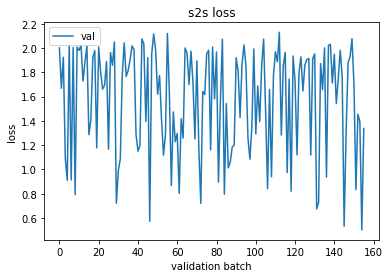

In [45]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_losses)
plt.title('s2s loss')
plt.ylabel('loss')
plt.xlabel('validation batch')
plt.legend(['val'], loc='upper left')
plt.show()


In [37]:
ppl_history = [math.exp(element) for element in history_losses]

In [38]:
ppl_history

[7.401569384091747,
 5.305494040838343,
 6.851094604747271,
 2.978610776135173,
 2.4861794393920755,
 7.604487234773502,
 2.4933974573121422,
 7.426247012798271,
 2.209854879380099,
 7.453448173169029,
 7.248379878768373,
 7.583020245700817,
 5.6365671936275,
 6.580672312086951,
 7.5305932785640275,
 3.620049064031539,
 4.072842267902409,
 6.818800493241702,
 7.234352263952897,
 3.2487322922976016,
 7.4629222612403225,
 6.047635434652449,
 5.268125563433368,
 5.446163199944857,
 6.615468473691674,
 3.2118818265305307,
 7.124073182893038,
 6.416326963837874,
 7.773816461208732,
 2.0578529397545227,
 2.6981499841989454,
 2.962662682745858,
 5.905065839214226,
 7.712470570886095,
 5.849982809020504,
 6.140874479913906,
 6.72053536027523,
 7.52776600190644,
 7.291767365164226,
 3.62977182567591,
 3.1607882647849515,
 3.314137354236698,
 7.973457641801244,
 7.641463364397081,
 4.038978936038186,
 6.825095780466938,
 1.7743974081849911,
 7.034031462117038,
 8.300334494346313,
 7.276442162513

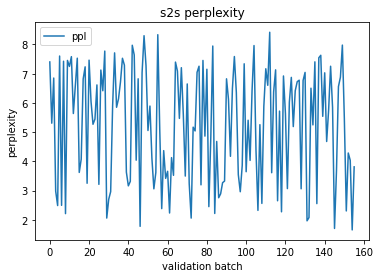

In [46]:
import keras
from matplotlib import pyplot as plt
plt.plot(ppl_history)
plt.title('s2s perplexity')
plt.ylabel('perplexity')
plt.xlabel('validation batch')
plt.legend(['ppl'], loc='upper left')
plt.show()


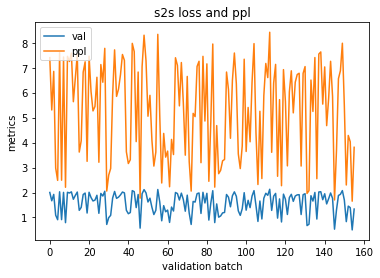

In [47]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_losses)
plt.plot(ppl_history)
plt.title('s2s loss and ppl')
plt.ylabel('metrics')
plt.xlabel('validation batch')
plt.legend(['val','ppl'], loc='upper left')
plt.show()


In [43]:

import statistics
statistics.mean(history_losses)


1.578375620337633

In [44]:
statistics.mean(ppl_history)

5.259862837911942

In [50]:

torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/style_transfer/training_files//save/gooderbuoy1024.pth')

In [21]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/save/goodboy1024.pth'))

RuntimeError: ignored

In [54]:
##eval


model.eval()  # turn on evaluation mode
#total_loss = 0.
results=[]
#src_mask = generate_square_subsequent_mask(bptt).to(device)
with torch.no_grad():
  for i, batch in enumerate(dataloader):
    source, targets = batch_preprocess(batch[0].to(device),batch[1].to(device),0)
    targets = targets.type(torch.int64)

    token_mask = (source != pad_idx).float()
    #targets = targets.unsqueeze(-1)
    #source = batch[0]
    #targets = batch[1]

    #src_mask = generate_square_subsequent_mask(source.size(0)).to(device)
    batch_size = batch[0].size(0)
    output = model(source, targets)
    output = output.type(torch.float)

    results.append((targets,output))
    #output_flat = output.view(-1, ntokens)
    #total_loss += batch_size * criterion(output, targets).item()
    
    
    
#return total_loss / (batch_size - 1)

KeyboardInterrupt: ignored

#Save Sentences

In [ ]:
def tensor2text(vocab, tensor):
    tensor = tensor.cpu().numpy()
    text = []
    index2word = vocab.itos
    eos_idx = vocab.stoi['<EOS>']
    unk_idx = vocab.stoi['<UNK>']
   # stop_idxs = [vocab.stoi['!'], vocab.stoi['.'], vocab.stoi['?']]
    for sample in tensor:
      sample_filtered = []
      prev_token = None
      for idx in list(sample):
        if idx == unk_idx or idx == prev_token or idx == eos_idx:
          continue
        prev_token = idx
        sample_filtered.append(index2word[idx])
          
      sample = ' '.join(sample_filtered)
      text.append(sample)

    return text

In [57]:
gold_res=[]
style_res=[]
for i in range(len(results)):
  gold_res.append(tensor2text(vocab,results[i][0]))
  style_res.append(tensor2text(vocab,results[i][1].argmax(-1)))

In [60]:
print(gold_res[100])
print(style_res[100])

['<SOS>', 'patients', 'with', 'unexplained', 'or', 'sustained', 'worsening', 'of', 'symptoms', 'should', 'be', 'evaluated', 'for', 'pancreatic', 'cancer', ',', 'particularly', 'if', 'assessment', 'reveals', 'a', 'pancreatic', 'duct', 'stricture', '.', '', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'patients', 'with', 'in', 'or', '<PAD>', 'weak', 'of', 'symptoms', 'should', 'be', ',', 'for', 'be', 'to', ',', 'to', 'if', ',', '.', 'a', 'be', 'and', 'may', '.', '', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [88]:
with open("/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/gold_res_s2s.txt", "w") as output:
  for each_list in gold_res:
    listToStr = ' '.join([str(elem) for elem in each_list])


    output.write(listToStr + '\n')

In [85]:
with open("/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/style_res_seq2seq.txt", "w") as output:
  for each_list in style_res:
    listToStr = ' '.join([str(elem) for elem in each_list])


    output.write(listToStr + '\n')

In [52]:
tensor2text(vocab,results[0][0])

['<SOS>',
 'in',
 'adults',
 ',',
 'lassitude',
 ',',
 'weakness',
 ',',
 'and',
 'anorexia',
 'are',
 'most',
 'common',
 '.',
 '',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [53]:
tensor2text(vocab,results[0][1].argmax(-1))

['<SOS>',
 'in',
 'usually',
 ',',
 '<PAD>',
 ',',
 ',',
 ',',
 'and',
 'a',
 'are',
 'most',
 'common',
 '.',
 '',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

#Bleu and save

In [63]:
  
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu

import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [73]:

def nltk_bleu(texts_origin, text_transfered):
  
  
  return sentence_bleu(texts_origin, text_transfered) * 100


In [72]:
sentence_bleu(gold_res[0],style_res[0])

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6303647413359293

In [74]:

bleu_scores_raw = []
for i in range(len(gold_res)):
  bleu_scores_raw.append(sentence_bleu(gold_res[i],style_res[i]))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [75]:
bleu_scores_raw

[0.6303647413359293,
 0.5734090813814468,
 0.6104735835807844,
 0.5307712171072443,
 0.5491004867761125,
 0.5542089483371553,
 0.42379865741502165,
 0.5695988432761473,
 0,
 0.5516251532744788,
 0.5900468726392808,
 0.6389431042462724,
 0.5318295896944989,
 0.5246341022861458,
 0.5491004867761125,
 0.668740304976422,
 0.6238986072117501,
 0.5577503997480662,
 0.5856596027429395,
 0.5659119256652702,
 0.6192596340984008,
 0.5318295896944989,
 0.5401203412164636,
 0.5039843787265444,
 0.5266403878479265,
 0.42728700639623407,
 0.6481388934544839,
 0.5491004867761125,
 0.537284965911771,
 0.476895599763377,
 0,
 0.6063062848485936,
 0.4728708045015879,
 0.5946035575013605,
 0.46575793908279883,
 0.6428039633283764,
 0.5193071778680676,
 0.5169731539571706,
 0.5577503997480662,
 0.7311104457090247,
 0,
 0.668740304976422,
 0.4591497693322866,
 0.6147881529512643,
 0.4386913376508308,
 0.6337268058487422,
 0.5169731539571706,
 0.46439804737625334,
 0.5318295896944989,
 0.5623413251903491,
 

In [76]:

import statistics
statistics.mean(bleu_scores_raw)

0.5225426159438799

In [86]:
with open("/content/drive/My Drive/Colab Notebooks/style_transfer/training_files/seq2seq_bleu.txt", "w") as output:
  for line in bleu_scores_raw:
    output.write(str(line) + '\n')